In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

### Load Frames

In [ ]:
def load_video_frames(path, color=False):
    vid = cv2.VideoCapture(path)
    frames = []
    while vid.isOpened():
        ret, frame = vid.read()
        if not ret:
            break

        conversion = cv2.COLOR_BGR2RGB if color else cv2.COLOR_BGR2GRAY
        frame = cv2.cvtColor(frame, conversion)
        frames.append(frame)
    
    vid.release()
    return np.array(frames)

color_frames = load_video_frames("cropped_cat_video.mp4", color=True)
frames = load_video_frames("cropped_cat_video.mp4")


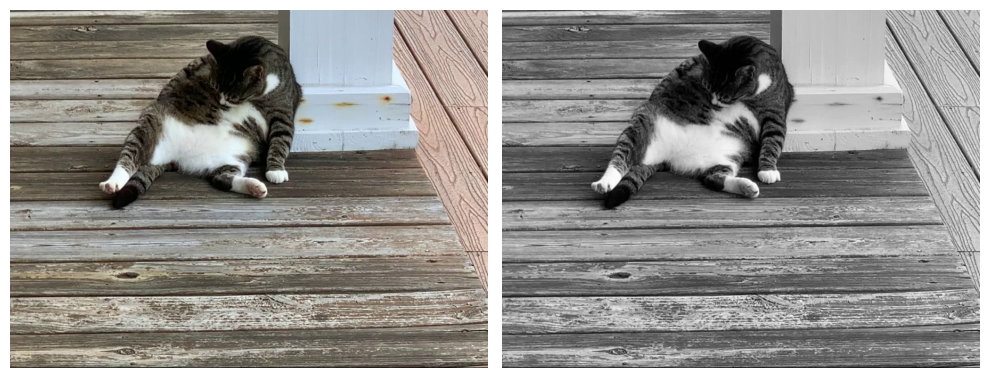

In [141]:
def show_frames(*frames):
    for i, f in enumerate(frames):
        plt.subplot(np.ceil(len(frames) / 2).astype(int), 2, i+1)
        plt.imshow(f, cmap="gray")
        plt.axis("off")
    plt.gcf().set_figwidth(10)
    plt.gcf().set_figheight(7.5)
    plt.tight_layout()
    plt.show()

show_frames(color_frames[0], frames[0])

### Image Gradient

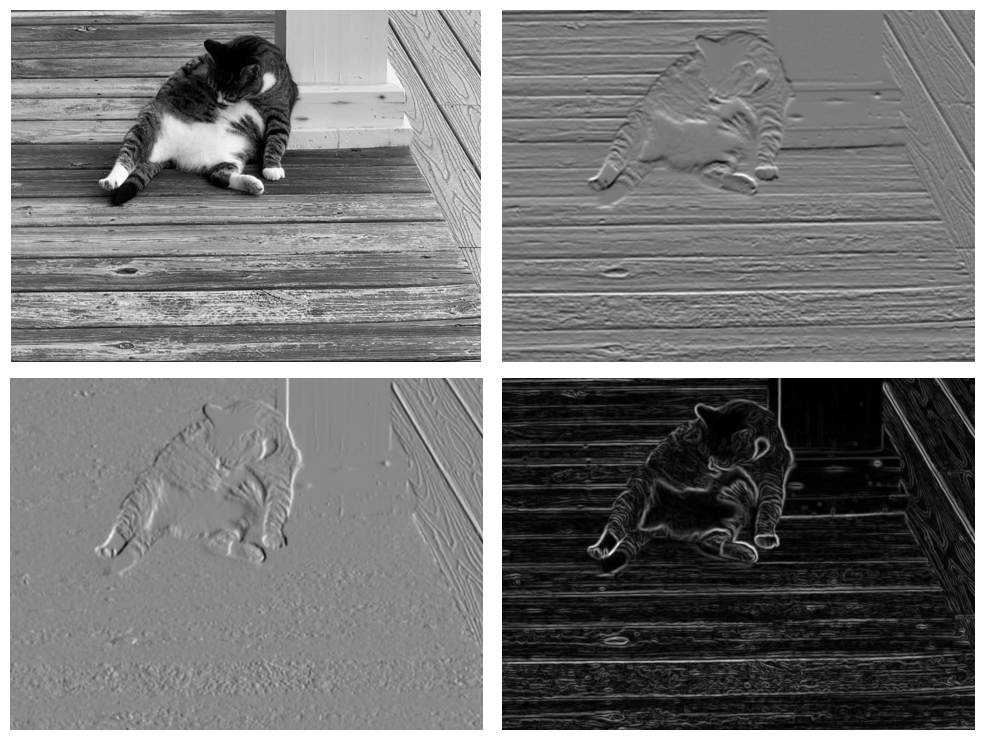

In [267]:
def gaussian_kernel(sigma):
    # determine range for truncation (3.5 sigma)
    h = np.ceil(3.5 * sigma)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front and normalize after
    kernel = np.exp(-0.5*(x / sigma)**2)
    norm_factor = np.convolve(np.ones_like(kernel), kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def deriv_kernel(sigma):
    # get derivative of gaussian
    # determine range for truncation (3.5 sigma)
    h = np.ceil(3.5 * sigma)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front because will rescale anyways
    kernel = -x * np.exp(-0.5*(x / sigma)**2)

    # normalize so derivative on a unit ramp is correct
    unit_ramp = x  # by coincidence, we already made a unit ramp of the correct shape
    norm_factor = np.convolve(unit_ramp, kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def image_gradient(frame, sigma=2):
    d_kernel = deriv_kernel(sigma)
    g_kernel = gaussian_kernel(sigma)

    # smooth in one direction and differentiate in the other
    vert_deriv = convolve2d(frame, d_kernel.reshape(-1, 1), mode="valid")
    vert_deriv = convolve2d(vert_deriv, g_kernel.reshape(1, -1), mode="valid")
    horiz_deriv = convolve2d(frame, d_kernel.reshape(1, -1), mode="valid")
    horiz_deriv = convolve2d(horiz_deriv, g_kernel.reshape(-1, 1), mode="valid")
    return np.stack((vert_deriv, horiz_deriv), axis=2)

grad = image_gradient(frames[0])
grad_mag = np.linalg.norm(grad, axis=2)
show_frames(frames[0], grad[:,:,0], grad[:,:,1], grad_mag)

### Features to Track

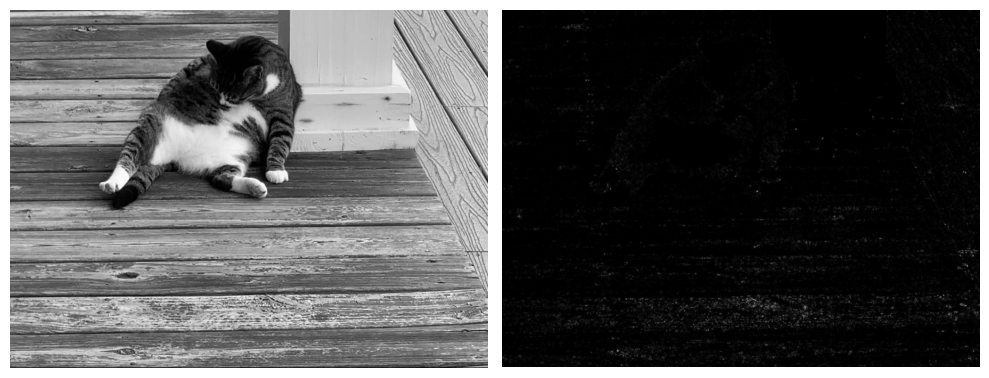

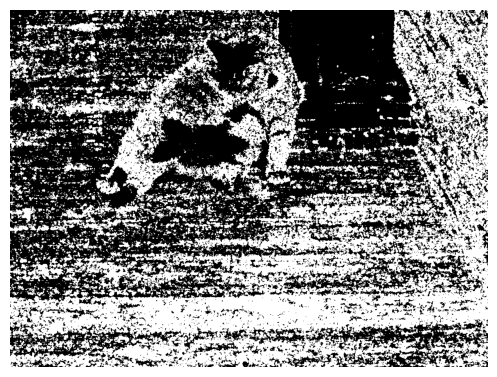

In [268]:
def smaller_eigenvalues(frame, window_size=5):
    assert window_size % 2 == 1, "Window size should be an odd number"
    h = (window_size - 1) / 2
    sigma = h / 3.5

    grad = image_gradient(frame, sigma)
    g_00 = grad[:, :, 0] ** 2
    g_01 = grad[:, :, 0] * grad[:, :, 1]
    g_11 = grad[:, :, 1] ** 2

    # convolve with window to get the 3 distinct elements of matrix A for each pixel
    # 3 not 4 because A is symmetric
    # do each element in two steps to exploit separability
    window_kernel = gaussian_kernel(sigma)
    a_00 = convolve2d(g_00, window_kernel.reshape(-1, 1), "valid")
    a_00 = convolve2d(a_00, window_kernel.reshape(1, -1), "valid")
    a_01 = convolve2d(g_01, window_kernel.reshape(-1, 1), "valid")
    a_01 = convolve2d(a_01, window_kernel.reshape(1, -1), "valid")
    a_11 = convolve2d(g_11, window_kernel.reshape(-1, 1), "valid")
    a_11 = convolve2d(a_11, window_kernel.reshape(1, -1), "valid")

    # use quadratic formula to solve for smaller eigenvalue
    # get b and c coefs for quadratic formula, a is 1
    b = - (a_00 + a_11)
    c = a_00*a_11 - a_01**2
    discrim = np.sqrt(np.maximum(0., b**2 - 4*c))  # max with 0 in case floating point error gives us barely negative numbers
    smaller_eigen = (-b - discrim) / 2
    return smaller_eigen


min_e  = smaller_eigenvalues(frames[0])
show_frames(frames[0], min_e)
show_frames(min_e > 5)

0.024997949600219727
0.027767658233642578
0.07591533660888672
Found 200 features!


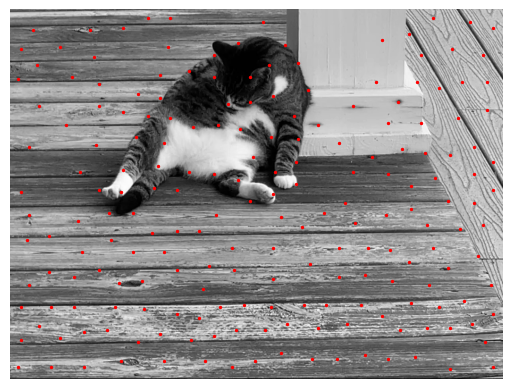

In [ ]:
import time
from scipy.ndimage import zoom

def features_to_track(frame, max_n=200, window_size=5, radius_frac=0.06, small_eig_threshold=10, zoom_factor=0.5):
    t0 = time.time()

    # resize to smaller version, since points should be trackable at that resolution
    # this also speeds up computation significantly
    frame = zoom(frame, zoom_factor)

    radius = radius_frac * frame.shape[0]

    small_eigs = smaller_eigenvalues(frame, window_size)

    print(time.time() - t0)
    
    # get indices of locations we have small eigs for
    # this is a smaller region than the image b/c we used valid convolutions
    offset = (frame.shape[0] - small_eigs.shape[0]) // 2
    r, c = np.indices(small_eigs.shape) + offset
    eigs_and_indices = np.dstack((small_eigs, r, c)).reshape(-1, 3)

    # remove pixels failing the small eigenvalue threshold
    meet_threshold = eigs_and_indices[:, 0] >= small_eig_threshold
    eigs_and_indices = eigs_and_indices[meet_threshold]

    # sort by eigenvalue
    sort_indices = np.argsort(-eigs_and_indices[:, 0])
    eigs_and_indices = eigs_and_indices[sort_indices]

    print(time.time() - t0)

    # use non-max suppression to choose features to track
    features = []
    for _ in range(max_n):
        if eigs_and_indices.shape[0] == 0:
            break
        pixel = eigs_and_indices[0, 1:]
        features.append(pixel)
        # remove pixels close to this feature
        sq_dist = np.sum((eigs_and_indices[:,1:] - pixel)**2, axis=1)
        eigs_and_indices = eigs_and_indices[sq_dist > radius ** 2]

        # remove pixels in a square region around this feature - is a bit faster
        # deltas = np.abs(eigs_and_indices[:, 1:] - pixel)
        # keep_mask = (deltas[:,0] > radius) | (deltas[:,1] > radius)
        # eigs_and_indices = eigs_and_indices[keep_mask]


    print(time.time() - t0)
    
    return np.array(features) / zoom_factor


features = features_to_track(frames[0], max_n=200, zoom_factor=0.25)
print(f"Found {features.shape[0]} features!")
plt.imshow(frames[0], cmap="gray")
plt.scatter(features[:,1], features[:,0], s=2, c="red")
plt.axis("off")
plt.show()